In [14]:
# Import necessary libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import basinhopping
from shapely.geometry import LineString, Point

In [15]:
# Defining normalised starting variables, based on a good guess
x0 = [0.59, 0.17, 0.05, 0.15]

#Defining stepsize
stepsize = 0.001 

# Defining bounds for optimisation 
bounds_t = (1e-3, 10e-3) # Bounds for thickness between holes (m)
bounds_h = (1e-4, 1e-3) # Bounds for thickness of tension bar. The tension bar is modeled with same depth (= z direction) as metamaterial (m)
bounds_R1 = (5e-3, 0.05) # Bounds for small hole (m)
bounds_R2 = (5e-3, 0.05) # Bounds of large hole (m)

bnds = (bounds_t, bounds_h, bounds_R1, bounds_R2) # Defining a variable for all bounds

# Normalising bounds
bnds_normalised = ((0, 1),) * 4 # Normalising bounds for faster and better simulation. The order of the individual parameters differ a lot form eachother, normalising will reduce this problem.

# Defining  number of iterations and temperature for basinhopping
iterations = 100
Temp = 100 # Size of the hops between basins

In [16]:
# Function to define symbols for dimensions
def dimensions_symbols():
    a, b, k_t, k_l, th0, l0, theta = sp.symbols('a b K_t K_v theta_0 l_0 theta')
    return a, b, k_t, k_l, th0, l0, theta

In [17]:
# Function to define equations for dimensions
def dimensions_equations(a, b, theta, th0, l0):
    NoH = 1.5 # Number of holes in geometry
    H = 2 * NoH * (b * sp.sin(theta) + a * sp.cos(theta)) # Height of the geometry (m)
    W = 2 * NoH * (a * sp.sin(theta) + b * sp.cos(theta)) # Width of the geometry (m)
    uy = -(H - H.subs(theta, th0)) # Displacement in y-direction (m)
    l = 2 * b * sp.cos(theta) # Length of tension bar (m)
    return H, W, uy, l

In [18]:
# Function to define potential energy equations
def energy_equations(k_t, k_l, theta, th0, l0, l, uy):
    P_torsion = 0.5 * k_t * (theta - th0) ** 2 # Energy of torsion spring (J)
    P_linear = sp.Piecewise((0.5 * k_l * (l - l0) ** 2, l > l0), (0, True)) # Energy of linear spring (J)
    P = (12 * P_torsion) + (4 * P_linear) # Total spring energy (J)
    
    # Derivation from energy to force to stiffness
    duy = sp.diff(uy, theta)
    dP= sp.diff(P, theta)
    F = dP/ duy # Force (N)
    dF = sp.diff(F, theta)
    K = dF / duy # Stiffness (N/m)
    
    # Derivative to seperate torsion and lineair energy to force
    dP_t = sp.diff(P_torsion, theta)
    F_t = dP_t / duy # Force of torsion springs (N)
    dP_l = sp.diff(P_linear, theta)
    F_l = dP_l / duy # Force of linear springs (N)
    return P, F, K, F_l, F_t, P_torsion, P_linear

In [19]:
# Function to calculate parameters
def calculate_parameters(x):
    t = round(bounds_t[0] + x[0] * (bounds_t[1] - bounds_t[0]), 6) # spacing between holes (m)
    h = round(bounds_h[0] + x[1] * (bounds_h[1] - bounds_h[0]), 6) # thickness of tension-bar (m)
    R1 = round(bounds_R1[0] + x[2] * (bounds_R1[1] - bounds_R1[0]), 6) # radius of small holes (m)
    R2 = round(bounds_R2[0] + x[3] * (bounds_R2[1] - bounds_R2[0]), 6) # radius of large holes (m)
    E_linear = 0.165e6 # Young's modulus of tension-bars (Pa)
    E_torsion = 0.61e6 # Young's modulus of bulk (Pa)

    return t, h, R1, R2, E_linear, E_torsion

In [20]:
# Function to calculate other derived variables
def variable_defining(t, h, R1, R2, E_linear, E_torsion, Depth=5e-2):
    a = (2 * (R1 + 0.5 * t) ** 2) ** 0.5 # short side of rectangle in linkage model of geometry 
    b = (2 * (R2 + 0.5 * t) ** 2) ** 0.5 # long side of rectangle in linkage model of the geometry
    k_l = (Depth * h * E_linear) / R2 # stiffness of a linear spring
    D = (4 * R1 * R2) / (R1 + R2) # geometrical parameter required for torsional stifness calculation
    k_t = 0.093 * E_torsion * Depth * t ** 2 * (2 * (t / D) ** 0.5) # stiffness of a torsion spring
    return [a, b, k_t, k_l, t, h, R1, R2, E_linear, E_torsion]

In [21]:
# Function to simulate the linkage model of geometry
def model(x, stepsize = stepsize):
    
    # Retrieve functions outputs
    a, b, k_t, k_l, th0, l0, theta = dimensions_symbols()
    H, W, uy, l = dimensions_equations(a, b, theta, th0, l0)
    P, F, K, F_l, F_t, P_torsion, P_linear = energy_equations(k_t, k_l, theta, th0, l0, l, uy)
    t, h, R1, R2, E_linear, E_torsion = calculate_parameters(x)
    variables = variable_defining(t, h, R1, R2, E_linear, E_torsion)  # 
    
    params = {
        a: variables[0],  # m
        b: variables[1],  # m
        k_t: variables[2],  # Nm/rad
        k_l: variables[3],  # N/m
        th0: np.pi / 4,  # rad
        l0: l.subs({theta: np.pi / 4, b: variables[1], a: variables[0]}) * (4 / 6)  # m
    }
    
    # Converting the SymPy functions into functions that allow for fast numeric evaluation
    P_func = sp.lambdify(theta, P.subs(params))
    P_t_func = sp.lambdify(theta, P_torsion.subs(params))
    P_l_func = sp.lambdify(theta, P_linear.subs(params))
    K_func = sp.lambdify(theta, K.subs(params))
    F_func = sp.lambdify(theta, F.subs(params))
    F_t_func = sp.lambdify(theta, F_t.subs(params))
    F_l_func = sp.lambdify(theta, F_l.subs(params))
    uy_func = sp.lambdify(theta, uy.subs(params))
    l_func = sp.lambdify(theta, l.subs(params))
    th_list = np.linspace(np.pi/4, 0, int(1/stepsize)) # array of the steps of the compression angle theta
    
    # Searching the lowest value of K_func to obtain the inclination point in F_func 
    for theta_mid in np.arange(stepsize, np.pi/4 - stepsize, stepsize): # begin with first stepsize and end with pi/4 minus stepsize to bypass start and end defects
        Kval = K_func(theta_mid)
        Kval_next = K_func(theta_mid + stepsize)
        Kval_previous = K_func(theta_mid - stepsize)
        dKval_next = Kval_next - Kval
        dKval_previous = Kval - Kval_previous
        if dKval_next >= 0 and dKval_previous <= 0: # if next and previous value are higher give value
            break
        else: theta_mid = stepsize # gives a high value in costfunction, so effectively acts like a penalty
    
    return P_func, P_t_func, P_l_func, K_func, F_func,F_l_func, F_t_func, uy_func,l_func, th_list, params, t, h, R1, R2, E_linear, E_torsion, theta_mid

In [22]:
# Force bounds to define the length of the QZS region
def F_bounds(theta, x):
    P_func, P_t_func, P_l_func, K_func, F_func,F_l_func, F_t_func, uy_func,l_func, th_list, params, t, h, R1, R2, E_linear, E_torsion, theta_mid = model(x)
    F_max = F_func(theta) * 1.005 # maximum force bound, 0.5% above the inclination point
    F_min = F_func(theta) * 0.995 # minimum force bound, 0.5% below the inclination point
    return F_max, F_min 

In [23]:
# Calculation of the length of the QZS region within the force bounds
def length(intersection_coords_max, intersection_coords_min, k_max, k_min):
    if not k_max == 1 or not k_min == 1: # penalty if F_func doesn't have one intersection at each force bound 
        length = 3e-4
    else:
        length = intersection_coords_max[0][0] - intersection_coords_min[0][0] # length of QZS region with one intersection with each force bound  
        if intersection_coords_min[0][0] > intersection_coords_max[0][0]: # penalty if length is negative  
            length = 2e-4
    return length

In [24]:
# Costfunction to be minimized by the optimisation algorithm
def costfunction(x):   
    # Bounds for normalised parameters in basinhopping algorithm
    lower_bounds = [0, 0, 0, 0]
    upper_bounds = [1, 1, 1, 1]
    if not (np.all(x >= lower_bounds) and np.all(x <= upper_bounds)):
        # return infinity when values are out of bounds from the basinhopping algorithm
        return 1e10
    
    # Retrieve model outputs 
    P_func, P_t_func, P_l_func, K_func, F_func,F_l_func, F_t_func, uy_func,l_func, th_list, params, t, h, R1, R2, E_linear, E_torsion, theta_mid = model(x)
    
    F_max, F_min = F_bounds(theta_mid, x) # Retrieve F_bounds outputs
    bound_max = [F_max] * len(th_list) # making an array of maximum force bound value
    bound_min = [F_min] * len(th_list) # making an array of minimum force bound value
    
    #Making lines from the arrays to obtain intersection points
    line_F = LineString(np.column_stack((uy_func(th_list), F_func(th_list))))
    line_max = LineString(np.column_stack((uy_func(th_list), bound_max)))
    line_min = LineString(np.column_stack((uy_func(th_list), bound_min)))
    
    intersection_max = line_max.intersection(line_F) # intersection points with maximum force bound and F_func
    intersection_min = line_min.intersection(line_F) # intersection points with minimum force bound and F_func
    
    intersection_coords_max = [(0,0)] # initial intersection point necessary for optimisation
    
    #Intersection for the maximum force bound and F_func 
    if intersection_max.is_empty: # there is no intersection with maximum force bound and F_func
        k_max = 0
    elif isinstance(intersection_max, Point): # there is one intersection with maximum force bound and F_func
        k_max = 1
        intersection_coords_max = list(intersection_max.coords) # making a list from shapely output
    else: # there is more than one intersection with maximum force bound and F_func
        k_max = 0
    
    intersection_coords_min = [(0,0)] # initial intersection point necessary for optimisation
    
    #Intersection of the minimum force bound and F_func     
    if intersection_min.is_empty: # there is no intersection with minimum force bound and F_func
        k_min = 0
    elif isinstance(intersection_min, Point): # there is one intersection with minimum force bound and F_func
        k_min = 1
        intersection_coords_min = list(intersection_min.coords) # making a list from shapely output
    else: # there is more than one intersection with minimum force bound and F_func
        k_min = 0
            
    penalty = 0 # setting a initial penalty value

    # Adding penalties if needed, with different values, so they are traceable
    if K_func(th_list)[0] < 0: # If the stiffness starts negative
        penalty =+ 4000
    elif x[3] < x[2]: # If the small hole is bigger than the large hole
        penalty =+ 5000
    
    # Inverse length of the QZS region in relation to the total compression to be minimized  
    L = (uy_func(th_list)[-1] - uy_func(th_list)[0]) / length(intersection_coords_max, intersection_coords_min, k_max, k_min) + penalty
    
    return L

In [25]:
# Minimizing costfunction output with Scipy basinhopping algorithm for global minimum and trust-contraint algorithm for the local minima
results = basinhopping(costfunction, x0, niter=iterations, T=Temp, minimizer_kwargs={'method': 'trust-constr', 'bounds': bnds_normalised})
print(results)

C:\Users\tkrom\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


                        fun: 1.732125991999845
 lowest_optimization_result:  barrier_parameter: 5.120000000000003e-08
 barrier_tolerance: 5.120000000000003e-08
          cg_niter: 58
      cg_stop_cond: 0
            constr: [array([0.88548347, 0.20277776, 0.15615351, 0.53825088])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 53.208274364471436
               fun: 1.732125991999845
              grad: array([0., 0., 0., 0.])
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([ 4.95705713e-09, -7.00066850e-09, -6.15474075e-09,  1.72391881e-09])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 255
              nhev: 0
               nit: 59
             niter: 59
              njev: 51
        optimality: 7.000668

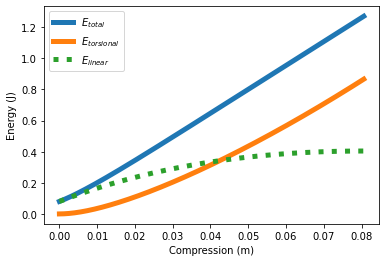

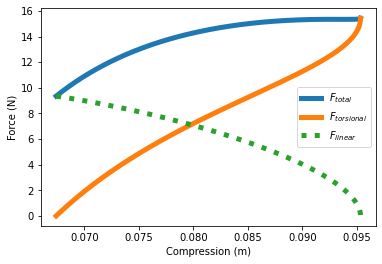

Normalised parameters t: 0.8854834745328464, h: 0.2027777619464005, R1: 0.15615350883649795, R2:0.538250875410297
Parameters t: 8.97, h: 0.27999999999999997, R1: 12.030000000000001, R2:29.22
Size of metamaterial = 25.11 cm
QZS region absolute = 46.53 mm
QZS region relative = 57.99999999999999 %


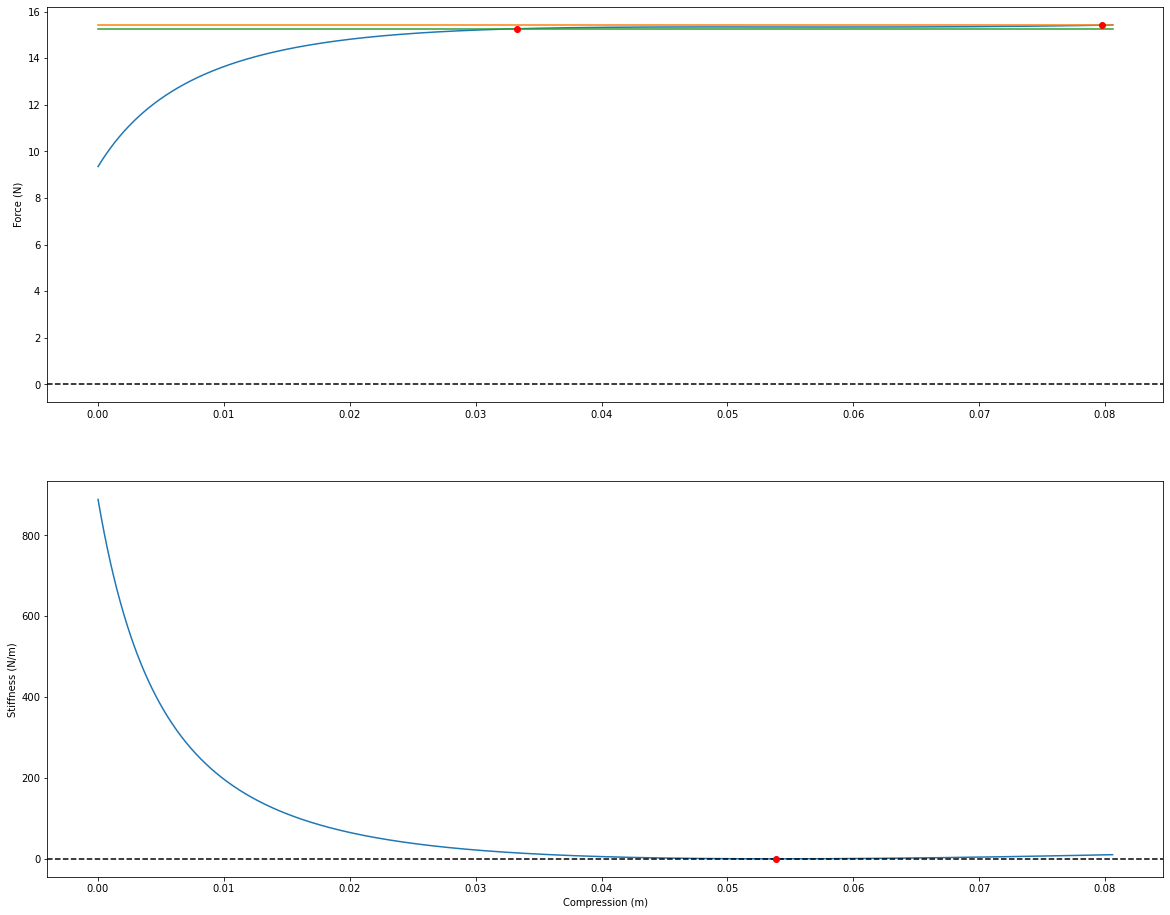

In [26]:
#Plotting the output of the optimisation

# Filling in the optimisation output into the relevant functions
P_func, P_t_func, P_l_func, K_func, F_func,F_l_func, F_t_func, uy_func, l_func, th_list, params, t, h, R1, R2, E_linear, E_torsion, theta_mid = model(results.x)
F_max, F_min = F_bounds(theta_mid, results.x)

variables = variable_defining(t, h, R1, R2, E_linear, E_torsion)

#plot of potential energy
fig, ax = plt.subplots(1, 1)
ax.plot(uy_func(th_list), P_func(th_list), label='$P_{total}$', lw=5)
ax.plot(uy_func(th_list), 12 * P_t_func(th_list), label='$P_{torsion}$', lw=5)
ax.plot(uy_func(th_list), 4 * P_l_func(th_list), label='$P_{linear}$', ls=':', lw=5)
ax.set_xlabel('Compression (m)')
ax.set_ylabel('Potential energy (J)')
ax.legend()
plt.show()

#plot of total force
fig, ax = plt.subplots(1, 1)
ax.plot(l_func(th_list), F_func(th_list), label='$F_{total}$', lw=5)
ax.plot(l_func(th_list), 12 * F_t_func(th_list), label='$F_{torsional}$', lw=5)
ax.plot(l_func(th_list), 4 * F_l_func(th_list), label='$F_{linear}$', ls=':', lw=5)
ax.set_xlabel('Compression (m)')
ax.set_ylabel('Force (N)')
ax.legend()
plt.show()

#redifining the intersections, lines of the bounds
bound_max = [F_max] * len(th_list) 
bound_min = [F_min] * len(th_list)
line_F = LineString(np.column_stack((uy_func(th_list), F_func(th_list))))
line_max = LineString(np.column_stack((uy_func(th_list), bound_max)))
line_min = LineString(np.column_stack((uy_func(th_list), bound_min)))
intersection_max = line_max.intersection(line_F)
intersection_min = line_min.intersection(line_F)

#plot E-, F- & K-function
fig, ax = plt.subplots(2, 1, figsize=(20, 16))
ax[0].plot(uy_func(th_list), F_func(th_list))
ax[1].plot(uy_func(th_list), K_func(th_list))
ax[0].plot(uy_func(th_list), bound_max)
ax[0].plot(uy_func(th_list), bound_min)
ax[0].axhline(0, color='k', ls='--')
ax[1].axhline(0, color='k', ls='--')
ax[1].plot(uy_func(theta_mid), K_func(theta_mid), 'ro')
ax[0].set_ylabel('Force (N)')
ax[1].set_ylabel('Stiffness (N/m)')
ax[1].set_xlabel('Compression (m)')

# Plotting the intersection points
if intersection_max.is_empty: # There is no intersection
    k_max = 0
elif isinstance(intersection_max, Point): # The intersection is a single point
    k_max = 1
    intersection_coords_max = list(intersection_max.coords)
    ax[0].plot(*intersection_max.xy, 'ro')
else: # There are multiple intersections
    k_max = 0
    for geom in intersection_max.geoms:
        intersection_coords_max = list(geom.coords)
        for n in range(len(intersection_max.geoms)):
            ax[0].plot(*intersection_max.geoms[n].xy, 'ro')
      
if intersection_min.is_empty: # There is no intersection
    k_min = 0
elif isinstance(intersection_min, Point): # The intersection is a single point
    k_min = 1
    intersection_coords_min = list(intersection_min.coords)
    ax[0].plot(*intersection_min.xy, 'ro')
else: # There are multiple intersections
    k_min = 0
    for geom in intersection_min.geoms:
        intersection_coords_min = list(geom.coords)
        for n in range(len(intersection_min.geoms)):
            ax[0].plot(*intersection_min.geoms[n].xy, 'ro')

#print outputspecs
print('Normalised parameters', f"t: {results.x[0]}, h: {results.x[1]}, R1: {results.x[2]}, R2:{results.x[3]}")
print('Parameters', f"t: {round(variables[4], 5)*1e3}, h: {round(variables[5], 5)*1e3}, R1: {round(variables[6], 5)*1e3}, R2:{round(variables[7], 5)*1e3}")
print('Size of metamaterial =', round(5 * (variables[4] + variables[6] + variables[7]), 4)*100, 'cm')
print('QZS region absolute =', round(length(intersection_coords_max, intersection_coords_min, k_max, k_min) * 1000, 2), 'mm')
print('QZS region relative =', round(length(intersection_coords_max, intersection_coords_min, k_max, k_min) / (uy_func(th_list)[-1] - uy_func(th_list)[0]), 2)*100, '%')

plt.show()


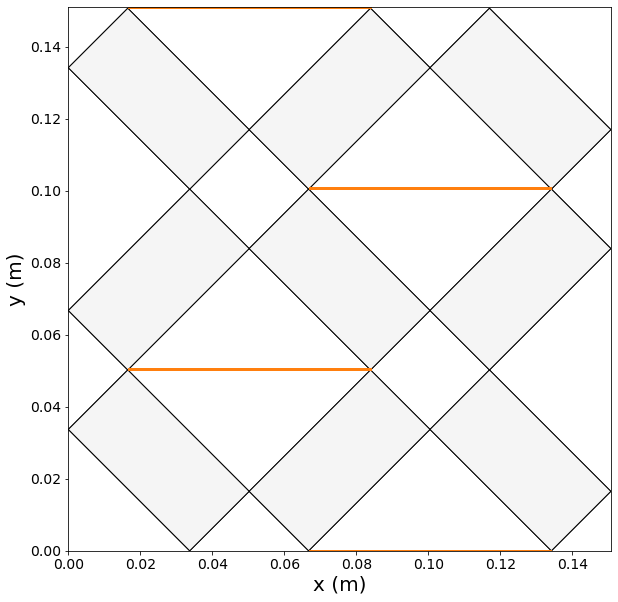

0.150651
0.150651


In [28]:
# Visualisation of the linkage model
def make_rectangle(xy, a, b, angle):
    r = Rectangle(xy=xy,
                  width=b, height=a,
                  angle=180 * angle / np.pi,
                  fc='whitesmoke', ec='k')
    return r


def make_line(xy, a, b, angle):
    l = Rectangle(xy=xy,
                  width=b, height=a,
                  angle=180 * angle / np.pi,
                  fc='tab:orange', ec='tab:orange')  #tab:orange 
    return l


def draw_mechanism(params, theta):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    rectangles = []
    w = variables[0] * np.sin(theta) + variables[1] * np.cos(theta)
    h = variables[0] * np.cos(theta) + variables[1] * np.sin(theta)
    rectangles.append(make_rectangle(xy=(0, variables[1] * np.sin(theta)),
                                     a=variables[0], b=variables[1], angle=-theta))
    rectangles.append(make_rectangle(xy=(variables[0] * np.sin(theta) + w, 0),
                                     a=variables[0], b=variables[1], angle=theta))
    rectangles.append(make_rectangle(xy=(2 * w, variables[1] * np.sin(theta)),
                                     a=variables[0], b=variables[1], angle=-theta))
    rectangles.append(make_rectangle(xy=(variables[0] * np.sin(theta), h),
                                     a=variables[0], b=variables[1], angle=theta))
    rectangles.append(make_rectangle(xy=(w, h + variables[1] * np.sin(theta)),
                                     a=variables[0], b=variables[1], angle=-theta))
    rectangles.append(make_rectangle(xy=(variables[0] * np.sin(theta) + 2 * w, h),
                                     a=variables[0], b=variables[1], angle=theta))
    rectangles.append(make_rectangle(xy=(0, variables[1] * np.sin(theta) + 2 * h),
                                     a=variables[0], b=variables[1], angle=-theta))
    rectangles.append(make_rectangle(xy=(variables[0] * np.sin(theta) + w, 2 * h),
                                     a=variables[0], b=variables[1], angle=theta))
    rectangles.append(make_rectangle(xy=(2 * w, variables[1] * np.sin(theta) + 2 * h),
                                     a=variables[0], b=variables[1], angle=-theta))
    rectangles.append(make_line(xy=(variables[0] * np.sin(theta), h - 0.0001),
                                a=0.6e-3, b=2 * variables[1] * np.sin(theta), angle=0))
    rectangles.append(make_line(xy=(variables[0] * np.sin(theta) + w, 2 * h - 0.0001),
                                a=0.6e-3, b=2 * variables[1] * np.sin(theta), angle=0))
    rectangles.append(make_line(xy=(variables[0] * np.sin(theta) + w, 0),
                                a=0.3e-3, b=2 * variables[1] * np.sin(theta), angle=0))
    rectangles.append(make_line(xy=(variables[0] * np.sin(theta), 3 * h),
                                a=0.3e-3, b=2 * variables[1] * np.sin(theta), angle=0))
    for r in rectangles:
        ax.add_patch(r)
    for l in rectangles:
        ax.add_patch(l)
    ax.set_aspect(1)
    ax.set_xlim(0, 3 * h)
    ax.set_ylim(0, 3 * h + 0.0003)
    ax.set_xlabel('x (m)', fontsize=20)
    ax.set_ylabel('y (m)', fontsize=20)
    ax.tick_params(axis='both', labelsize=14)
    plt.show()

draw_mechanism(params, np.pi / 4)